In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
from osgeo import osr
from osgeo import ogr
from osgeo import gdal
from shapely.geometry import LineString, shape, mapping
import fiona
from shapely import affinity
import matplotlib.pyplot as plt
import traceback
import datetime
import numpy as np
from rasterio.plot import show
import richdem as rd
import earthpy.spatial as es
import urllib
import rasterio as rio
import os
os.chdir(r'd:\work\leman')
import warnings
warnings.filterwarnings("ignore")

def export_raster(arr, name, transform, crs='epsg:4326'):
    new_dataset = rio.open(name, 'w', driver='GTiff',
                                height = arr.shape[0], width = arr.shape[1],
                                count=1, dtype=str(arr.dtype),
                                crs=crs,
                                transform=transform)

    new_dataset.write(arr, 1)
    new_dataset.close()

In [19]:
# TODO parameters: lat, lon, automate EPSG choice
station_meters = 250 # distance beetween sampling points
conNum = 35 # number of countorus
flat_areas_slope = 4 # flat areas - below this slope areas will not be drawn, teraz to kompletnie nie pasuje!
multiplier = 500 # na tatrach byl 5 - jak go wyznaczac - on jest zalezny wprost od jednostek slope!
map_title = 'TATRA MOUNTAINS'
folder_shp = r'.\shp'
folder_res = r'.\results'


In [3]:
url = r'https://portal.opentopography.org/API/globaldem?demtype=SRTMGL3&south=50&north=51&west=20&east=21&outputFormat=GTiff&API_Key=d216d4befdd891d39fc6db5b4ddf4a8e'
raster_dem_path = r".\files\dem.tif"
urllib.request.urlretrieve(url, raster_dem_path)
crs_adequate = 'EPSG:2180' # idenfify automatically

('.\\files\\dem.tif', <http.client.HTTPMessage at 0x1ad28558bb0>)

In [6]:
input_raster = gdal.Open(raster_dem_path)
raster_dem_epsg_path = r".\files\dem_epsg.tif"
warp = gdal.Warp(raster_dem_epsg_path, input_raster, dstSRS=crs_adequate)
warp = None # Closes the files

with rio.open(raster_dem_epsg_path) as src:
    elevation = src.read(1)

dem = rd.LoadGDAL(raster_dem_epsg_path)

hillshade = es.hillshade(elevation)
transform = src.transform
raster_hs_path = r'.\files\hs.tif'
export_raster(hillshade, raster_hs_path, transform, crs=crs_adequate)

slope = rd.TerrainAttribute(dem, attrib='slope_riserun')
raster_slope_path = r'.\files\slope.tif'
export_raster(slope, raster_slope_path , transform, crs=crs_adequate)

aspect = rd.TerrainAttribute(dem, attrib='aspect')
raster_aspect_path = r'.\files\aspect.tif'
export_raster(aspect, raster_aspect_path, transform, crs=crs_adequate)

raster_slope = rio.open(raster_slope_path)
raster_aspect = rio.open(raster_aspect_path)
raster_hs = rio.open(raster_hs_path)
raster_dem = gdal.Open(raster_dem_epsg_path)
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))

show((raster_slope, 1), ax=axb, cmap='YlOrBr', title='slope')
show((raster_aspect, 1), ax=axg, cmap='jet', title='aspect', vmin=0)
show((raster_hs, 1), ax=axr, cmap='gray', title='hillshade')

# TODO exclude -9 999 from slopes

Maximum dem elevation: 612.00, minimum dem elevation: 0.00


<AxesSubplot:>

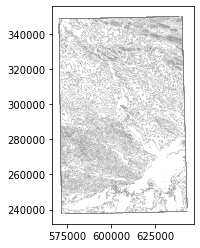

In [8]:
rasterBand = raster_dem.GetRasterBand(1)
proj = osr.SpatialReference(wkt=raster_dem.GetProjection())

elevArray = rasterBand.ReadAsArray()
demNan = -340282306073709652508363335590014353408.00
demMax = elevArray.max()
demMin = elevArray[elevArray!=demNan].min()
print("Maximum dem elevation: %.2f, minimum dem elevation: %.2f"%(demMax,demMin))
contourPath = f'{folder_shp}\contoursDefined_{conNum}.shp'
contourDs = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(contourPath)
contourShp = contourDs.CreateLayer(str(conNum), proj)

# define fields of id and elev
fieldDef = ogr.FieldDefn("ID", ogr.OFTInteger)
contourShp.CreateField(fieldDef)
fieldDef = ogr.FieldDefn("elev", ogr.OFTReal)
contourShp.CreateField(fieldDef)

# define number of contours and range
conList =[int(x) for x in np.linspace(demMin,demMax,conNum)]
gdal.ContourGenerate(rasterBand, int(demMin), int(demMax), conList, 1, demNan, contourShp, 0, 1)

contourDs.Destroy()
contour_gdf = gpd.read_file(f'{folder_shp}/contoursDefined_{conNum}.shp')
contour_gdf.plot(linewidth=0.2, color='gray')

2022-11-07 20:40:35.910057
2022-11-07 20:43:29.440775, station points processed, total number of points: 95229


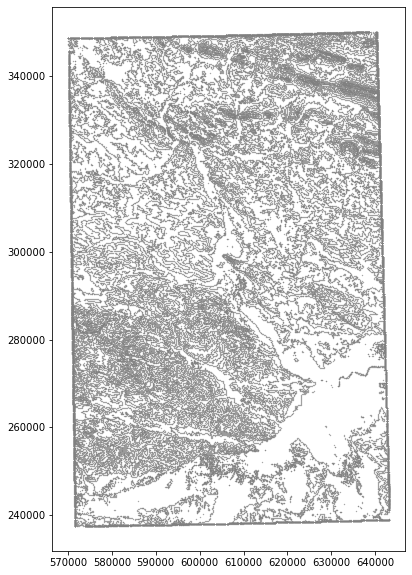

In [9]:
print(datetime.datetime.now())
line = fiona.open(f'{folder_shp}/contoursDefined_{conNum}.shp')
no_rows = len(line)

list_points = []
for feature in range(0,no_rows):
    points_st = (f'{folder_shp}/points_countur.shp')
    firstline = line.next()
    # transform to shapely geometry
    first = shape(firstline['geometry'])
    # length of the LineString
    length = first.length

    # creation of the resulting shapefile
    schema = {'geometry': 'Point','properties': {'id': 'int'},}
    with fiona.open(points_st, 'w', 'ESRI Shapefile', schema)  as output:
        # create points every station_meters  along the line
        for distance in range(0, int(length), station_meters):
            point = first.interpolate(distance)
            output.write({'geometry':mapping(point),'properties': {'id':1}})
    points_gdf = gpd.read_file(points_st)
    list_points.append(points_gdf)
    os.remove(f'{folder_shp}/points_countur.shp')

station_points_merged = pd.concat(list_points)
station_points_merged['x'] = station_points_merged['geometry'].apply(lambda p: p.x)
station_points_merged['y'] = station_points_merged['geometry'].apply(lambda p: p.y)
station_points_merged.to_file(fr'{folder_shp}/station_points_merged_{station_meters}.shp')
station_points_merged.plot(markersize=0.1, color='gray', figsize=(12,10))
print(f'{datetime.datetime.now()}, station points processed, total number of points: {station_points_merged.shape[0]}')

2022-11-07 20:49:04.623199
2022-11-07 20:49:51.246477


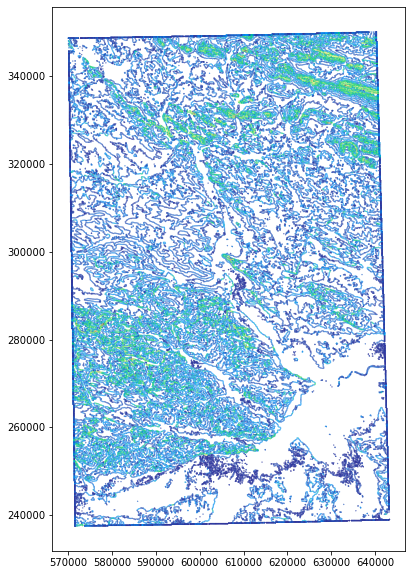

In [12]:
station_points_merged = gpd.read_file(fr'{folder_shp}/station_points_merged_{station_meters}.shp')
station_points_merged['x'] = station_points_merged['geometry'].apply(lambda p: p.x)
station_points_merged['y'] = station_points_merged['geometry'].apply(lambda p: p.y)
print(datetime.datetime.now())

for idx, row in station_points_merged.iterrows():
    try:
        for val in raster_hs.sample([(row.x, row.y)]):
            station_points_merged.at[idx, 'hs'] = val[0]
    except:
        pass
    try:
        for val in raster_aspect.sample([(row.x, row.y)]):
            station_points_merged.at[idx, 'aspect'] = val[0]
    except:
        pass
    try:
        for val in raster_slope.sample([(row.x, row.y)]):
                station_points_merged.at[idx, 'slope'] = val[0]
    except:
        pass

station_points_merged = station_points_merged.dropna()
station_points_merged = station_points_merged.loc[station_points_merged.slope > 0]
station_points_merged.to_file(fr'{folder_shp}\points_slope_aspect_{conNum}_{station_meters}.shp')
station_points_merged.plot(column='slope', markersize=0.1, cmap = 'terrain', figsize=(12,10))
print(datetime.datetime.now())

In [20]:
station_points_merged = gpd.read_file(fr'{folder_shp}\points_slope_aspect_{conNum}_{station_meters}.shp')
print(datetime.datetime.now())
list_lines = []
for point in station_points_merged.itertuples():
    try:
        input_l = LineString([(point.x - multiplier * point.slope, point.y), (point.x + multiplier * point.slope, point.y)])
        input_l_rot = affinity.rotate(input_l, point.aspect, (point.x, point.y))
        line_gs = GeoSeries(input_l_rot)
        line_gdf = gpd.GeoDataFrame(geometry=line_gs)
        line_gdf['hs'] = point.hs
        list_lines.append(line_gdf)
    except Exception as e:
        traceback.print_exc()

gdf_lines = pd.concat(list_lines)
gdf_lines.to_file(fr'{folder_res}\l_{conNum}_{station_meters}_{multiplier}.shp')
print(datetime.datetime.now())

2022-11-07 21:00:57.656417
2022-11-07 21:03:08.058330


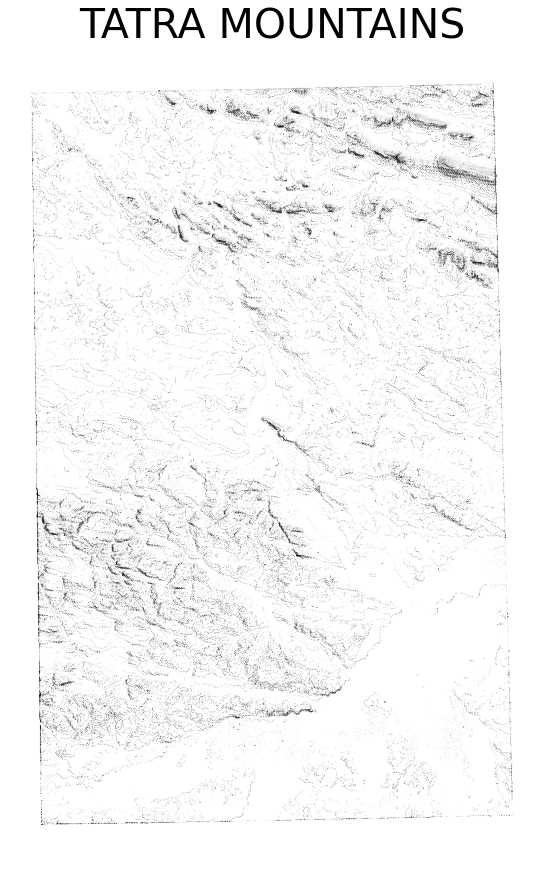

In [21]:
line_width = 0.9
transparency = 0.7
fig, ax = plt.subplots(figsize=(20,15))
hfont = {'fontname':'DejaVu Sans'}
ax.set_title(map_title, fontsize=41, **hfont)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
gdf_lines.plot(ax = ax, column='hs', linewidth=line_width, alpha=transparency, cmap='gray', vmin=150, vmax=255)
plt.savefig(fr'{folder_res}\l_{map_title}_{conNum}_{station_meters}_{multiplier}_{line_width}.jpg')